### Test the trained MLP on Fashion-MNIST dataset. What do you observe? Compare t-SNE plots for MNIST and Fashion-MNIST embeddings for the layer with 20 neurons.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from torchsummary import summary


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.8.0+cu126
No GPU found, using CPU instead.


In [4]:
# define a function to set all seeds to 0
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

In [19]:


# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_fashionmnist = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset_fashionmnist = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

combined_dataset = ConcatDataset([train_dataset_fashionmnist, test_dataset_fashionmnist])

batch_size = 60


combined_loader = DataLoader(dataset=combined_dataset, batch_size=1, shuffle=True)


In [8]:
print(f"Number of batches in combined_loader: {len(combined_loader)}")
for images, labels in combined_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break

Number of batches in combined_loader: 70000
Image batch shape: torch.Size([1, 1, 28, 28])
Label batch shape: torch.Size([1])


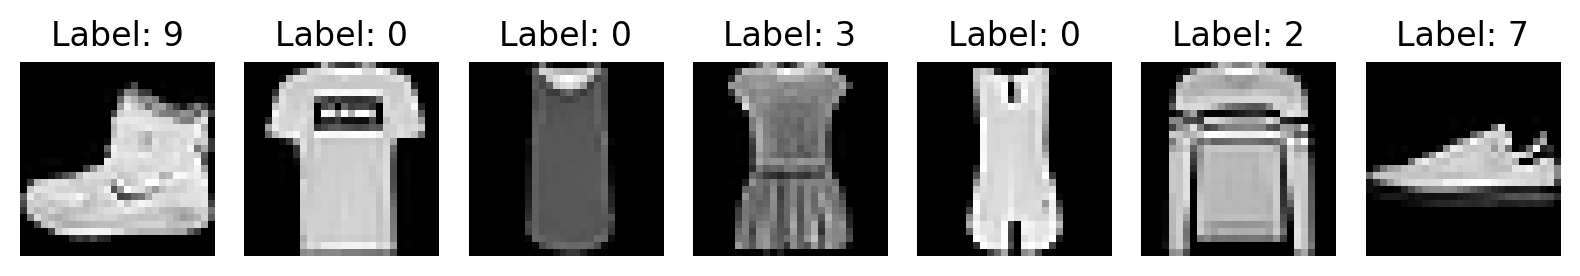

In [9]:
fig, axs = plt.subplots(1, 7, figsize=(8, 10))

for i in range(7):
    image, label = combined_dataset[i]
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].set_title(f'Label: {label}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [10]:
class MLP(nn.Module):
    def __init__(self, hidden_1, hidden_2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out, x

In [12]:
hidden_1=30
hidden_2=20

In [13]:
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs,_ = model(images) # Use only the first element of the tuple
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Store predictions and true labels
            _, predicted = torch.max(outputs.data, 1)
            y_train_pred = predicted.cpu().numpy()
            y_train_true = labels.cpu().numpy()
            y_train_prob = F.softmax(outputs, dim=1).cpu().detach().numpy()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * (correct_train / total_train)
        train_loss = total_train_loss / len(train_loader)

        # Evaluate on test data
        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0



        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs, _ = model(images) # Use only the first element of the tuple
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                y_test_pred = predicted.cpu().numpy()
                y_test_true = labels.cpu().numpy()
                y_test_prob = F.softmax(outputs, dim=1).cpu().detach().numpy()
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_loss = total_test_loss / len(test_loader)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.4f}%, Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.4f}%')

    return model, train_loss, train_accuracy, test_loss, test_accuracy, y_train_true, y_train_pred, y_train_prob, y_test_true, y_test_pred, y_test_prob

In [14]:
trained_model = MLP(hidden_1, hidden_2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trained_model.parameters(), lr=0.001)
print(trained_model)

summary(trained_model, (1, 28, 28))

MLP(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]          23,550
            Linear-2                   [-1, 20]             620
            Linear-3                   [-1, 10]             210
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [20]:
trained_model, train_loss, train_accuracy, test_loss, test_accuracy, y_train, y_train_pred, y_train_prob, y_test, y_test_pred, y_test_prob = train_and_evaluate_model(
    trained_model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

Epoch [10/20], Train Loss: 0.103777, Train Accuracy: 96.8933%, Test Loss: 0.129491, Test Accuracy: 96.2100%
Epoch [20/20], Train Loss: 0.062690, Train Accuracy: 98.0483%, Test Loss: 0.134912, Test Accuracy: 96.4000%


In [21]:
def predict_model(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    y_prob = []
    hidden_outputs = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs, hidden_output = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_prob.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())
            hidden_outputs.extend(hidden_output.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_prob), np.array(hidden_outputs)

y_true, y_pred, y_prob, hidden_outputs = predict_model(trained_model, combined_loader)

Accuracy: 15.42%
F1 Score: 0.14888
Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.06      0.06      7000
           1       0.76      0.54      0.63      7000
           2       0.00      0.01      0.00      7000
           3       0.15      0.46      0.23      7000
           4       0.00      0.00      0.00      7000
           5       0.15      0.14      0.14      7000
           6       0.11      0.04      0.06      7000
           7       0.20      0.02      0.03      7000
           8       0.40      0.29      0.33      7000
           9       0.00      0.00      0.00      7000

    accuracy                           0.15     70000
   macro avg       0.18      0.15      0.15     70000
weighted avg       0.18      0.15      0.15     70000



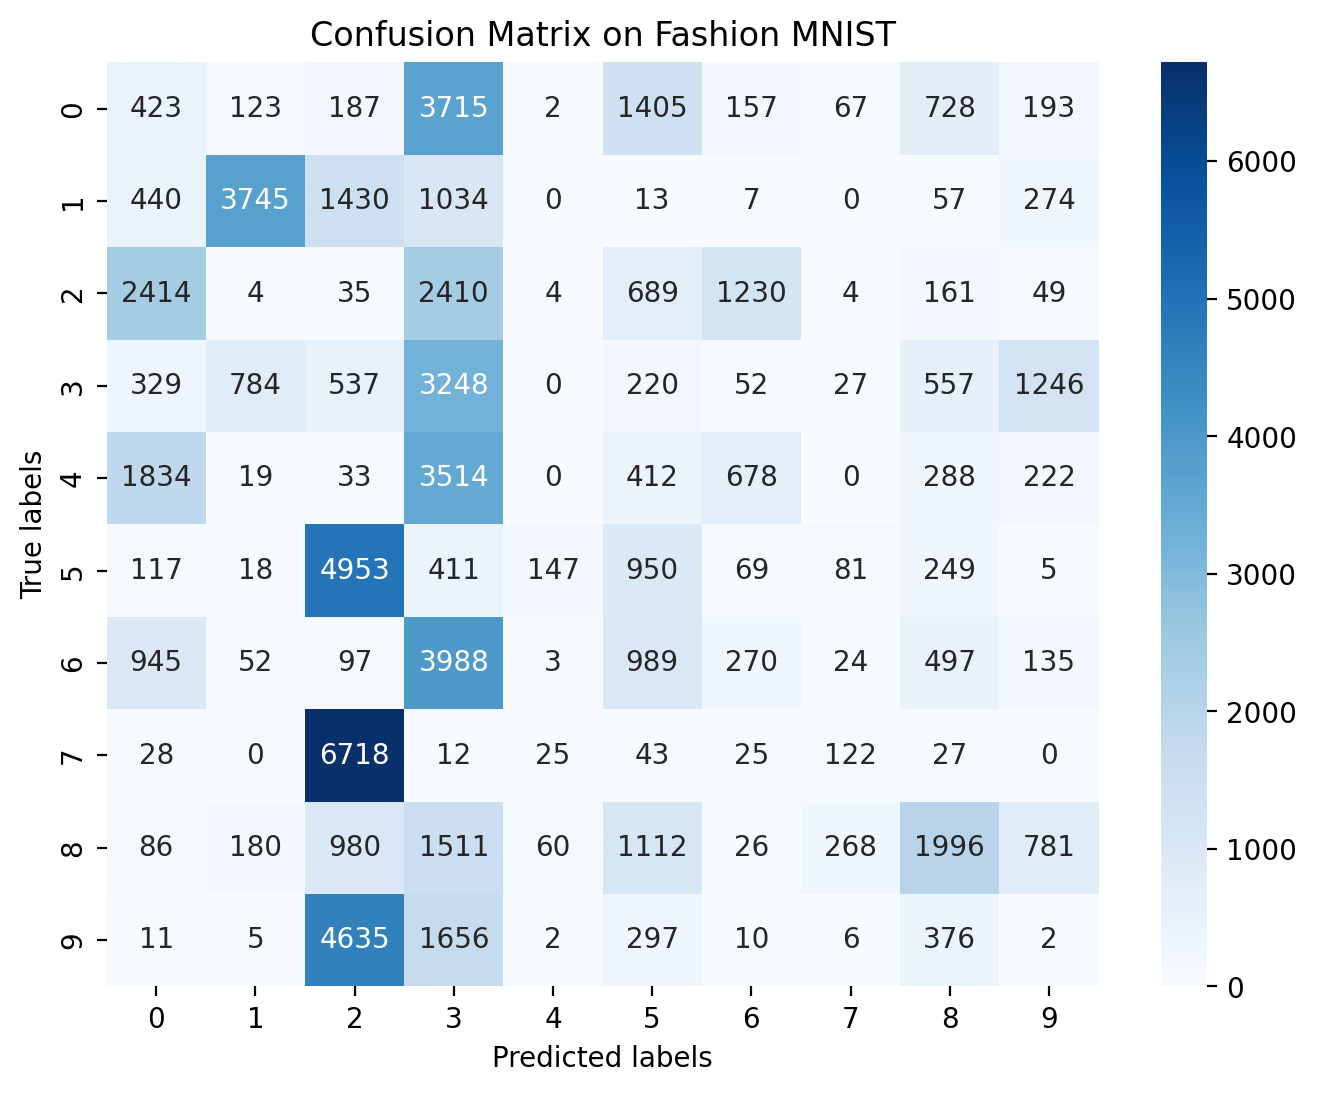

In [22]:
# accuracy, f1 score, confusion matrix, classification report
accuracy = np.mean(y_true == y_pred) * 100
f1 = f1_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}%")
print(f"F1 Score: {f1:.5f}")
# print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{cr}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Fashion MNIST')
plt.show()

## TSNE

In [25]:

from openTSNE import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
tsne_hidden = tsne.fit(hidden_outputs)

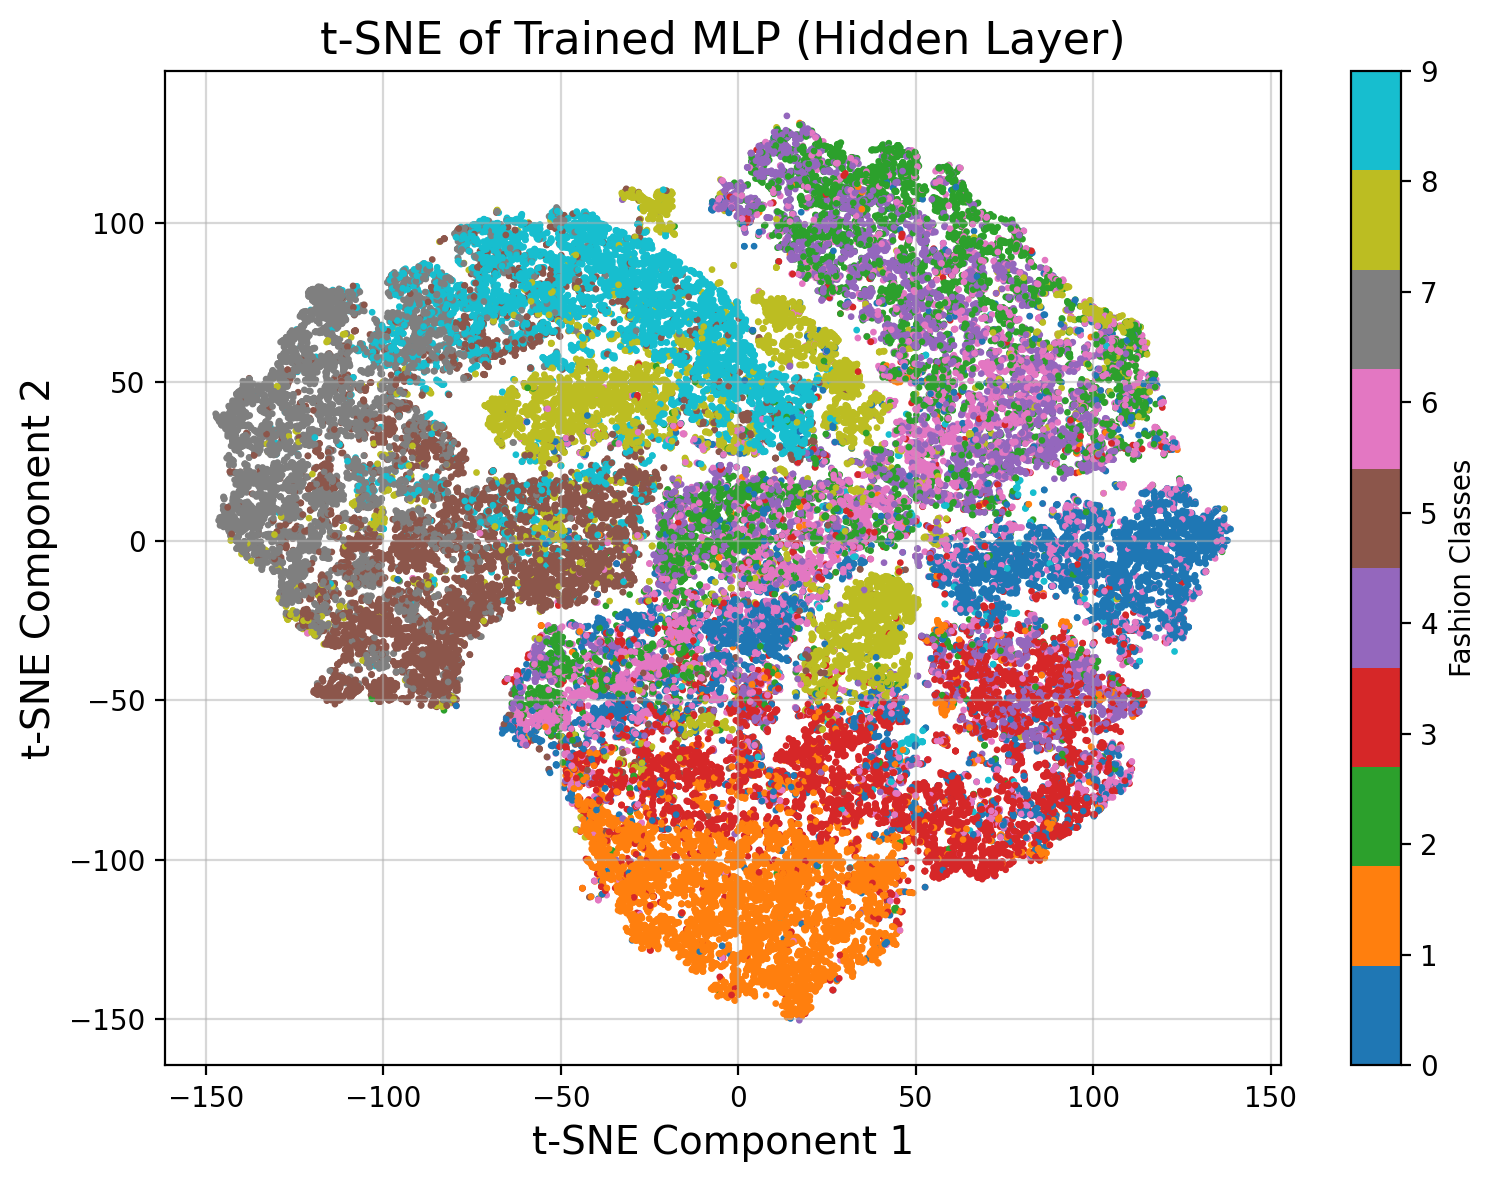

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(tsne_hidden[:, 0], tsne_hidden[:, 1], c=y_true, cmap='tab10', alpha=1, s=2)
ax.set_title('t-SNE of Trained MLP (Hidden Layer)', fontsize=16)
ax.set_xlabel('t-SNE Component 1', fontsize=14)
ax.set_ylabel('t-SNE Component 2', fontsize=14)
ax.grid(True, alpha=0.5)
fig.colorbar(scatter, ax=ax, label='Fashion Classes')

plt.tight_layout()
plt.show()

## Observations on Using the Trained MLP on the Fashion-MNIST Dataset

When the trained MLP model, originally developed for the MNIST dataset, was applied to the Fashion-MNIST dataset, the following observations were made:

- Model Performance: The model achieved an accuracy of approximately 15.42% and a F1 score of 0.14888 on the Fashion-MNIST dataset, which is significantly lower than the accuracy and F1 score achieved on the MNIST dataset. This low accuracy indicates that the model is not well-suited to the new dataset.
- The confusion matrix reveals that many predictions are concentrated on a few classes, especially class 2 (Pullover) and class 3 (Coat). This indicates that the model has likely learned to associate some features of Fashion-MNIST images with those of the MNIST digits, leading to systematic misclassifications.

### t-SNE Visualization for Fashion-MNIST
- When comparing the t-SNE visualization of the MNIST embeddings to those of Fashion-MNIST, we can observe differences in clustering patterns:
   - MNIST Clusters: The t-SNE visualization for MNIST displays clear and well-defined clusters, indicating that the model effectively learned to separate digit classes.
   - Fashion-MNIST Overlap: In contrast, the t-SNE visualization for Fashion-MNIST showed more overlap and less distinct clustering. This suggests that the model has not learned robust features that can differentiate between the various clothing items.

## Conclusion

In summary, the application of the trained MLP on the Fashion-MNIST dataset demonstrates significant limitations in the model's ability to generalize across different image domains. The low accuracy and poor clustering in the t-SNE visualization indicate that the model has not effectively adapted to the fashion classification task.